<a href="https://colab.research.google.com/github/peterjsadowski/Tutorial-Microbiome/blob/main/part3_topic_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Models for Microbiome Data

This tutorial demonstrates how to use topic modeling methods for document analysis on microbiome data. Following the approach of [Sankaran and Holmes](https://academic.oup.com/biostatistics/article/20/4/599/5032578), we apply topic models using the following analogy:

Document <-> Biological Sample
Term <-> Bacterial species
Topic <-> Community
Word <-> Sequencing read
Corpus <-> Environment

Latent Dirichlet Allocation (LDA) is a statistical model for high-dimensional data. It is **generative model** because it describes a data-generating process. In this model, a document of words are generated in the following way (following the notation in Sankaran and Holmes).

1. K topics are defined. A topic is represented by a Categorical distribution over words in a dictionary. Each topic is randomly sampled from a Dirichlet distribution. 

2. D topic-mixtures are defined (one for each of D documents). A topic-mixture $\theta_d$ for document $d$ is a Categorical distribution over the K topics. Each topic mixture is randomly sampled from another Dirichlet.

3. For each document $d$, sample $N_d$ words. Each word is sampled by first sampling a topic $k$ from $\theta_d$, then sampling a word from the selected topic $\beta_k$. This can described compactly as sampling from a Multinomial($N_d$, B($\theta_d$)) where B=($\beta_1,\ldots\beta_K$).




# Importing packages
We need to install the *gensim* package, which implements the topic modeling functionality. 

In [2]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import collections
from tqdm import tqdm
import scipy

from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import Dictionary


# Upload data

If using colab, we need to upload the data files found [here](https://github.com/peterjsadowski/Tutorial-Microbiome/tree/main/data/waimea). This contains 1410 biological samples derived from [Amend, et al. 2022](https://www.pnas.org/doi/10.1073/pnas.2204146119). 

In [ ]:
data_path = './'  # For colab. Change to './data/waimea' if running locally.
FILE_OTU = data_path + 'rel_abund_MM_16S_otu_table.csv'
FILE_SAMPLE = data_path + 'rel_abund_MM_16S_sample_data.csv'
FILE_TAXONOMY = data_path + 'rel_abund_MM16S_taxonomy.csv'

# Create "Document Corpus"

In topic models, a document is represented as a "bag of words" (BoW) in which the order of the words doesn't matter. This is a huge simplification, but is sufficient for many applications. For example, you can probably guess the topic of a document containing the words "invasion", "Ukraine", and "missiles", or another document containing "health", "microbiome", and "RNA-Seq". (Chat-GPT is a much more sophisticated generative language model, in which the order of the words is taken into account.)

The LDA model uses the BoW represention. This makes sense for our use case in analyzing 16S data, because the order of the sequencing reads doesn't matter --- each sample is treated as a "bag of reads". However, LDA has the nice property that it allows a single document to be a mix of different topics. For example, an article about the public health impacts of the war might contain a mixture of the topics mentioned above. Similarly, each biological sample can contain a mixture of distinct microbe communities. 

We start the analysis by reading in the OTU table and representing the data in the data structures expected by gensim.

In [27]:
def get_corpus(file_otu, file_sample):
    """
    Read data and represent it as a 'corpus' analagous to a collection of documents.
    """
    df = pd.read_csv(file_otu, index_col=0) # 5747 OTUs by 1410 samples
    df = (df * 10000).astype(int) # Processed data is subsampled to 10k and converted to relative abundance.
    samples = pd.read_csv(file_sample, index_col=0)  # 1410 samples by 54 features
    
    # Create corpus. 
    corpus = []
    for sample in tqdm(df.columns):
        doc = []
        for otu, count in zip(df.index, df[sample]):
            doc.extend([otu]*count) # Inefficient as hell, but couldn't figure other way to use gensim.Dictionary.
        corpus.append(doc)

    dct = Dictionary(corpus)
    print(dct.num_docs, dct.num_nnz, dct.num_pos, len(dct.token2id)) #(1646, 1732685, 127704384, 257910)
    dct.filter_extremes(no_below=10, no_above=0.5)
    print(dct.num_docs, dct.num_nnz, dct.num_pos, len(dct.token2id)) # (1646, 1732685, 127704384, 35118)
    temp = dct[0]  # This is only to "load" the dictionary for dct.id2token.
    corpus_bow = [dct.doc2bow(sample) for sample in corpus] # Convert to Bag of Words (bow) representation.
    return dct, corpus_bow, df

# Logging suggested for LDAModel in https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 

# Load data.
dct, corpus_bow, df = get_corpus(FILE_OTU, FILE_SAMPLE)

# Each element of list corpus_bow represents a document, with each document 
# represented by a list of (token, count) tuples.

print(f'Element (i,j) of DataFrame df contains count of OTU i for sample j.')
print(f'Element i of list corpus_bow is a list of non-zero (token, count) tuples.')


100%|██████████| 1410/1410 [00:04<00:00, 346.95it/s]


1410 224498 14066223 5747
1410 224498 14066223 3678
Element (i,j) of DataFrame df contains count of OTU i for sample j.
Element i of list corpus_bow is a list of non-zero (token, count) tuples.


# Train LDA model.

The following code trains the LDA model on the dataset. The learning algorithm is an iterative procedure and takes some time. The following code takes three minutes on colab, and the model is saved so that it can be loaded later. It is an iterative optimization algorithm that keeps improving, so increasing the number of passes and iterations will make the model fit the training data better, but it will run slower. To speed this up, gensim includes a LdaMulticore model that you can try.

Alppha and eta are hyperparameters of the model that specify the priors for the topic mixtures and topics. This code will automatically choose them, but an expert could potentially choose them to match the properties of the data.

The number of topics is specified to be 20 here, but that is a good hyperparameter to tune. 


In [102]:
# Fit model to corpus. (3 minutes with these parameters on colab)
num_topics = 20 
model = LdaModel( 
            corpus_bow, 
            random_state=42,          # For reproducability.
            num_topics=num_topics,   
            chunksize = 2000, 
            alpha='auto', eta='auto', # Options unavailable in LDAMulticore?
            passes=50, iterations=50, eval_every=1)    # Takes 3min
            # passes=500, iterations=100, eval_every=1) # Takes 40min
model.save(f'{num_topics}topics_model.lda')

# Model can be reloaded from file using this command.
# model =  LdaModel.load(f'20topics_model.lda')

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


# Analyze the LDA model

The trained model has learned a set of topics (microbe communities) B=($\theta_1, \ldots, $\theta_K$), and the topic-mixture for each document (biological sample). We can extract these from the model. 

In [104]:
def get_topics(model, dct):
    '''
    Get topics as distribution of asvs. Column 1 are asvs. Other columns are PMFs over these asvs, one for each topic.
    Returns:
    df: pandas dataframe with col1 asv string, then 20 cols representing topics.
    '''
    num_asvs = len(dct.id2token)
    assert num_asvs == model.num_terms
    m = model.get_topics() # Shape: (num_topics, num_otus=35118)
    asv_list = [dct.id2token[i] for i in range(m.shape[1])]
    df = pd.DataFrame(data=m.T, index=asv_list)
    return df

# Create topic otu distributions. The first column contains the otu names. The next 20 columns contain the distributions over OTUs for each topic. 
topic_otus = get_topics(model, dct)
topic_otus.to_csv(f'{num_topics}topics_topic_otus.csv', header=False)
print('Topic matrix shape (num_otus, num_topics):', topic_otus.shape)

Topic matrix shape (num_otus, num_topics): (3678, 20)


In [105]:
def per_sample_topics(model, dct, corpus_bow, df):
    '''
    Returns:
    pmfs: num_samples x num_topics numpy array, where i,j is i sample j topic.
    '''
    sample_ids = df.columns
    num_samples = len(corpus_bow)
    assert num_samples == len(sample_ids)
    pmfs = np.zeros((num_samples, model.num_topics)) 
    for i,sample in enumerate(corpus_bow):
        tuples = model.get_document_topics(sample) # Get topic probability distribution for a document.
        # tuples = list(sorted(tuples, key=lambda x: x[1], reverse=True))
        #pmf = [t[1] for t in tuples]
        for topic, p in tuples:
            pmfs[i, topic] = p
    rval = pd.DataFrame(data=pmfs, index=sample_ids)
    return rval

# Create sample_topics. Each row is the sample name, followed by the fraction of the sample attributed to each of 20 topics.
sample_topics = per_sample_topics(model, dct, corpus_bow, df)
sample_topics.to_csv(f'{num_topics}topics_sample_topics.csv', header=False)
print('Topic matrix shape (num_otus, num_topics):', topic_otus.shape)
print('Sample topic-mixture matrix shape (num_samples, num_topics):', sample_topics.shape)

Topic matrix shape (num_otus, num_topics): (3678, 20)
Sample topic-mixture matrix shape (num_samples, num_topics): (1410, 20)



# Visualize Topics and Topic Mixtures

We can produce some plots to explore the topics that have been learned, and the topic-mixture associated with each document. 



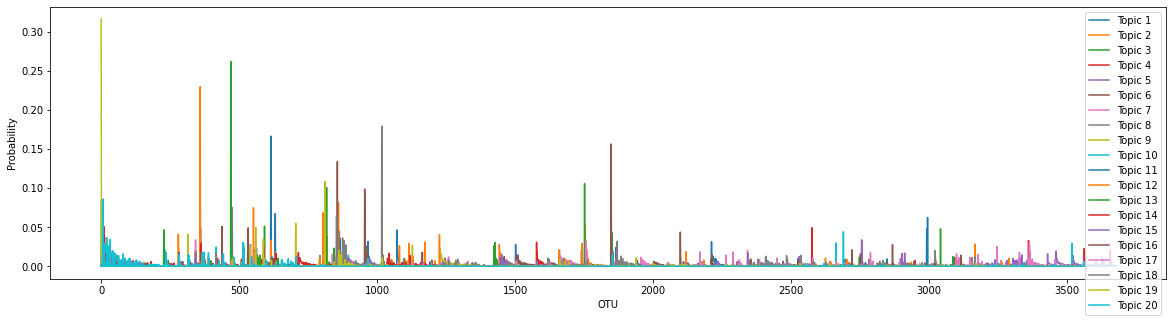

In [106]:
# Plot each topic as a distribution over OTUs.
x = topic_otus.to_numpy()
plt.figure(figsize=(20,5))
#plt.plot(x);
for i in range(x.shape[1]):
  plt.plot(x[:,i], alpha=1, label=f'Topic {i+1}')
plt.xlabel('OTU')
plt.ylabel('Probability')
plt.legend()


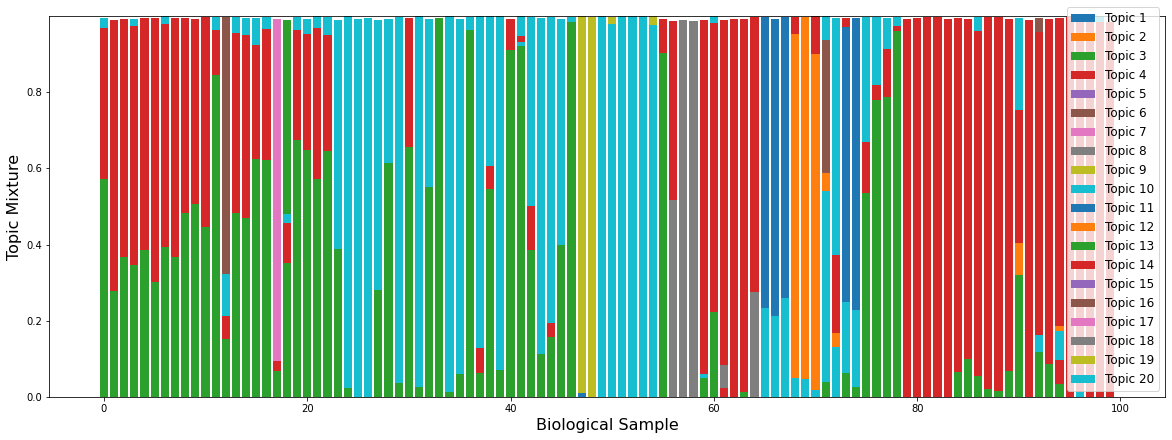

In [107]:
# Plot each sample as a topic mixture
N = 100 # First N samples
x = sample_topics.to_numpy()
fig, ax = plt.subplots(figsize=(20,7))  
margin_bottom = np.zeros(N)
for i in range(x.shape[1]):
    values = x[:N, i]
    plt.bar(x=np.arange(N), height=values, bottom = margin_bottom, 
            label=f'Topic {i+1}')
    margin_bottom += values
plt.xlabel('Biological Sample', fontsize=16)
plt.ylabel('Topic Mixture', fontsize=16)
plt.legend(fontsize=12)
plt.show()

# Topic Modelling as Dimensionality Reduction

Topic models give us a way of summarizing any document as a mixture of topics. Representing documents in this way makes it easier to see "the big picture" and find patterns. For example, documents could be clustered using this representation, or classified (e.g. "science" vs. "non science"). In the raw BoW representation, there are many words that are highly correlated, and machine learning models will tend to overfit; topic modeling can help avoid that overfitting. 

Similarly, this model enables us to represent each biological sample as a mixture of microbe communities. It is possible (even likely) that the topics/communities found by LDA do not correspond to any fundamental interactions between these sets of microbes. Even so, the topic representation could provide a useful representation for analysis. The Sankaran paper demonstrates it's use in describing changes in microbiomes over time and other applications.

Below, we use PCA and UMAP methods to visualize the 1410 samples using both the topic model representation and the original count representation. 


In [108]:
# Get meta data and assign colors to samples.
from sklearn.preprocessing import LabelEncoder

def assign_colors(colorby='trophic'):
  """ Assign a integer label and color to each unique value in the colorby col.
  Returns:
    labels = List of label names. Has length equal to len(df.columns).
    colors = List of colors. Has length equal to len(df.columns).
    label_colors = Dict mapping unique keys to colors.
  """
  labels = pd.read_csv(FILE_SAMPLE)['trophic']
  encoder = LabelEncoder()
  labels_int = encoder.fit_transform(labels)
  cmap = plt.get_cmap('Accent')
  num_labels = len(np.unique(labels))
  label_colors = {label: cmap(i/num_labels) 
                  for i, label in enumerate(np.unique(labels))}
  colors = [label_colors[label] for label in labels]
  return labels, colors, label_colors

labels, colors, label_colors = assign_colors()

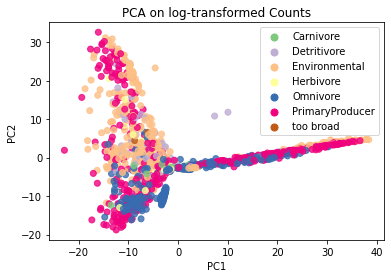

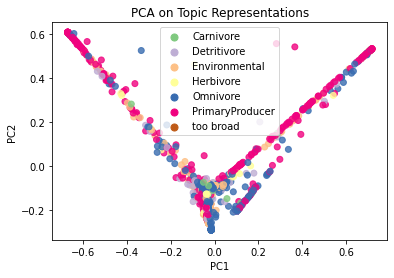

In [109]:
from sklearn.decomposition import PCA

# PCA on BoW counts
pca = PCA()
components = pca.fit_transform(np.log(1+df.T))
plt.figure(1)
plt.title('PCA on log-transformed Counts')
plt.scatter(components[:,0], components[:,1], alpha=0.8, color=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_scatterplots = [plt.scatter([], [], s=50, color=color, label=label)
                      for label, color in label_colors.items()]
plt.legend(handles=legend_scatterplots)

# PCA on Topics
pca = PCA()
components = pca.fit_transform(x)
plt.figure(2)
plt.title('PCA on Topic Representations')
plt.scatter(components[:,0], components[:,1], alpha=0.8, color=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_scatterplots = [plt.scatter([], [], s=50, color=color, label=label)
                      for label, color in label_colors.items()]
plt.legend(handles=legend_scatterplots)

We can do the same thing with the UMAP method.

In [ ]:
!pip install umap-learn
import umap 

CPU times: user 10.8 s, sys: 273 ms, total: 11 s
Wall time: 9.97 s
CPU times: user 7.95 s, sys: 219 ms, total: 8.17 s
Wall time: 6.78 s


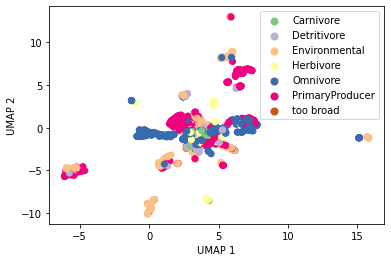

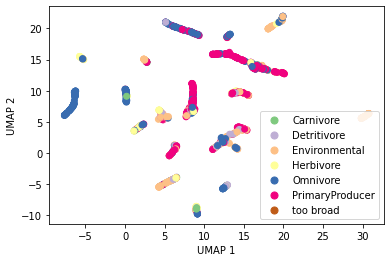

In [110]:

# UMAP on BoW Counts
fit = umap.UMAP()
%time u = fit.fit_transform(np.log(1+df.T))
plt.figure(1)
plt.scatter(u[:,0], u[:,1], color=colors)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
legend_scatterplots = [plt.scatter([], [], s=50, color=color, label=label)
                      for label, color in label_colors.items()]
plt.legend(handles=legend_scatterplots)

# UMAP on Topic Representation
fit = umap.UMAP()
%time u = fit.fit_transform(x)
plt.figure(2)
plt.scatter(u[:,0], u[:,1], color=colors)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
legend_scatterplots = [plt.scatter([], [], s=50, color=color, label=label)
                      for label, color in label_colors.items()]
plt.legend(handles=legend_scatterplots)




# Topic Modelling as Transfer Learning

Importantly, a topic model can be fit to *unlabeled* data, and the resulting topic representation can be used to model other data. 

In [ ]:

data_path = './'  # For colab. Change to './data/lyons/' if running locally.
FILE_OTU_LYONS = data_path + 'OTUs.100.rep.count_table.csv'
FILE_SAMPLE_LYONS = data_path + 'brom_meta.csv'
FILE_TAXONOMY_LYONS = data_path + 'OTUs.100.cons.taxonomy.csv'

In [ ]:
# Transform Lyons data into Waimea OTUs
df_taxons_waimea = pd.read_csv(FILE_TAXONOMY)
df_taxons_lyons = pd.read_csv(FILE_TAXONOMY_LYONS)
# TODO: Need to merge these to find mapping between OTUs.
# TODO: transform lyons into Waimea OTU
# TODO: transform lyons into BoW representation
# TODO: transform lyons into topic representation
